In [31]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

def rng(seed=100): return default_rng(seed)

days = 7
freq = 1
N = 24 * freq

h0 = 60
wcc = 2

random_generator = rng()

outdoor_temperature = 5 * np.sin(np.linspace(0, days * 2 * np.pi, days * N)) + random_generator.normal(0, .5, days * N).cumsum()
heating_power = h0 - wcc * outdoor_temperature
time = pd.date_range("2018-01-01 06:00:00", tz='utc', periods=days * N, freq="H")

df = pd.DataFrame({'building': np.repeat(['a', 'b'], 2 * days * N),
                   'room': np.repeat(['green', 'grey', 'green', 'grey'], days * N),
                   'time': np.tile(time, 4),
                   'heating_power': np.tile(heating_power, 4),
                   'outdoor_temperature': np.tile(outdoor_temperature, 4),
                   'indoor_temperature': 20
                   })
noise_level = .01 / freq

a = .1
b = .11
mult = 2
heating_coeffs = {'green': a, 'grey': b}
outdoor_coeffs = {'a': a * mult, 'b': b * mult}

for k, v in heating_coeffs.items():
    print(f'Heating coefficient room {k}', v)
    
for k, v in outdoor_coeffs.items():
    print(f'Outdoor coefficient building {k}', v)


random_generator = rng()
for building in ['a', 'b']:
    for room in ['green', 'grey']:
        h = heating_coeffs[room]
        a = outdoor_coeffs[building]
    
        y = np.zeros(days * N)
        y[0] = h * h0 / (h+a)
        for t in range(1, N * days):
            y[t] = y[t-1] + h * (heating_power[t-1] - y[t-1]) + a * (outdoor_temperature[t-1] - y[t-1]) + random_generator.normal(0, noise_level)
        
        df.loc[(df['building'] == building) & (df['room'] == room), 'indoor_temperature'] = y

Heating coefficient room green 0.1
Heating coefficient room grey 0.11
Outdoor coefficient building a 0.2
Outdoor coefficient building b 0.22


Let's visualize the simulated temperatures:

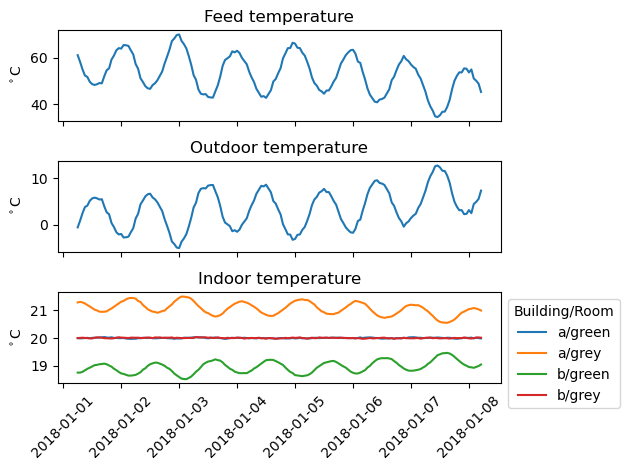

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
axes[0].set_title('Feed temperature')
axes[0].plot(time, heating_power)
axes[0].set_ylabel('$^\circ$C')

axes[1].set_title('Outdoor temperature')
axes[1].plot(time, outdoor_temperature)
axes[1].set_ylabel('$^\circ$C')

axes[2].set_title('Indoor temperature')
for building in ['a', 'b']:
    for room in ['green', 'grey']:
        idx = (df['building'] == building) & (df['room'] == room)
        axes[2].plot(df.loc[idx, 'time'], df.loc[idx, 'indoor_temperature'], label=f'{building}/{room}')
axes[2].legend(title='Building/Room', bbox_to_anchor=(1,1))
axes[2].set_ylabel('Indoor temperature')
plt.xticks(rotation=45)
plt.ylabel('$^\circ$C')
plt.tight_layout()

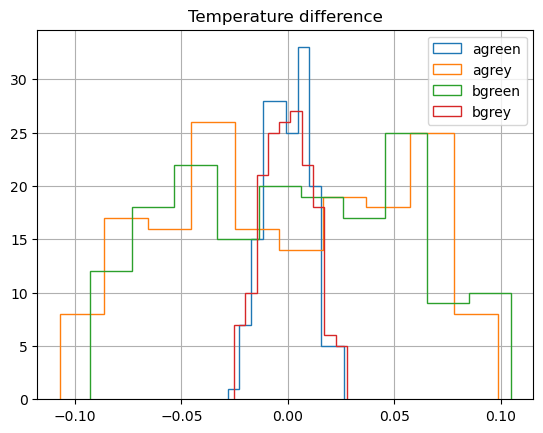

In [34]:
import matplotlib.pyplot as plt

df['group'] = df['building'] + df['room'].astype(str)

df['y'] = df.groupby('group')['indoor_temperature'].diff().shift(-1)

for k, subdf in df.groupby('group'):
    subdf['y'].hist(label=k, bins=10, histtype='step')

plt.title('Temperature difference')
plt.legend()

In [24]:
import arviz as az
import pymc as pm
from sakkara.model import RandomVariable as RV, Likelihood, data_components, build

outdoor = RV(pm.Normal, name='outdoor_temperature')

heating = RV(pm.Normal, name='heating_power')

data = data_components(df.loc[df['group'] == 'a1'].dropna())

temp_diff = heating * (data['heating_power'] - data['indoor_temperature']) + outdoor * (data['outdoor_temperature'] - data['indoor_temperature'])

likelihood = Likelihood(pm.Normal,
                        mu=temp_diff,
                        sigma=.01,
                        obs_data=data['y']
                       )

model = build(df.loc[df['group'] == 'a1'].dropna(), likelihood)
approx = pm.fit(method='advi', model=model, n=int(1e5))

az.summary(approx.sample(1000))

Finished [100%]: Average Loss = -407.54
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
heating_power[global],0.003,0.0,0.003,0.003,0.0,0.0,1002.0,908.0,NaN
outdoor_temperature[global],0.006,0.0,0.006,0.006,0.0,0.0,1030.0,1025.0,NaN


In [25]:
import arviz as az
import pymc as pm
from sakkara.model import RandomVariable as RV, Likelihood, data_components, build

outdoor = RV(pm.Normal, name='outdoor_temperature', columns='building')

heating = RV(pm.Normal, name='heating_power', columns='room')

data = data_components(df.dropna())

temp_diff = heating * (data['heating_power'] - data['indoor_temperature']) + outdoor * (data['outdoor_temperature'] - data['indoor_temperature'])

likelihood = Likelihood(pm.Normal,
                        mu=temp_diff,
                        sigma=.01,
                        obs_data=data['y']
                       )

model = build(df.dropna(), likelihood)
approx = pm.fit(model=model, n=int(1e5))

az.summary(approx.sample(1000))

Finished [100%]: Average Loss = -1,681.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
heating_power[1],0.093,0.0,0.093,0.093,0.0,0.0,874.0,1007.0,NaN
heating_power[2],0.102,0.0,0.102,0.102,0.0,0.0,977.0,850.0,NaN
outdoor_temperature[a],0.185,0.0,0.185,0.185,0.0,0.0,976.0,983.0,NaN
outdoor_temperature[b],0.204,0.0,0.204,0.204,0.0,0.0,1183.0,812.0,NaN


In [29]:
for k, v in heating_coeffs.items():
    print(f'Heating room {k}', v)
    
for k, v in outdoor_coeffs.items():
    print(f'Outdoor building {k}', v)

Heating room 1 0.1
Heating room 2 0.11
Outdoor building a 0.2
Outdoor building b 0.22
